In [1]:
import pandas as pd

In [2]:
import sqlite3

In [3]:
con = sqlite3.connect("../dbmining.sqlite")

In [4]:
df = pd.read_sql_query("""
SELECT p.owner, p.name, v.*
FROM project p, version v
WHERE p.id = v.project_id
ORDER BY p.id, date_commit
""", con)
df

,owner,name,id,sha1,isLast,project_id,part_commit,date_commit
0,Activiti,Activiti,1,d7bca2aa56c46540df42e388961cde2c4ffc9cb6,0,1,1,2010-07-08 12:23:23+00:00
1,Activiti,Activiti,2,e6241b0600d25c90260449a7b80e3db016ac448c,0,1,2,2010-07-29 07:38:01+00:00
2,Activiti,Activiti,3,791a9604d5cced8cfc718d1a51db9d90f506ecc0,0,1,3,2010-08-26 14:46:26+00:00
3,Activiti,Activiti,4,426dfc7fff016228dbd11c4150c6db254dce3cb6,0,1,4,2010-09-10 13:23:04+00:00
4,Activiti,Activiti,5,1b958f8f4e5e9b2cf60572e9fa58b08398dbefa1,0,1,5,2010-09-21 20:47:55+00:00
...,...,...,...,...,...,...,...,...
48741,RoaringBitmap,RoaringBitmap,40157,0a123061bd797a12ec6647e8b8d14ee35057e364,0,389,20,2020-04-25 02:32:30+00:00
48742,RoaringBitmap,RoaringBitmap,40158,b15cbe22eb1c62f108e506a2d2ecdbbdd3308ce2,0,389,21,2021-04-07 15:26:40+00:00
48743,RoaringBitmap,RoaringBitmap,40159,4d281190c38d2e92e0aeaf884494d7d703bc9210,0,389,22,2021-11-06 23:14:29+00:00
48744,RoaringBitmap,RoaringBitmap,40160,8211b6aed62d9b86be9c95bef691b80664e65da4,0,389,23,2022-11-14 22:27:49+00:00


In [5]:
from itertools import groupby

In [6]:
df["date_commit2"] = pd.to_datetime(df["date_commit"])

In [7]:
from datetime import datetime
import pytz
from collections import defaultdict

In [8]:
all_dates = set()
projects = {}
groups = groupby(df.iterrows(), lambda x: (x[1]['project_id'], x[1]['owner'], x[1]['name']))
for (project_id, owner, name), group in groups:
    projects[project_id] = info = {
        'id': project_id,
        'owner': owner,
        'name': name,
        'versions': {},
        'dates': {}
    }
    versions = list(group)
    first = versions[0][1]["date_commit2"]
    current_year = first.year if first.month < 7 else first.year + 1
    basedate =  datetime(current_year, 7, 1, tzinfo=pytz.UTC)
    previous = versions[0][1]
    for _, version in versions:
        while version["date_commit2"] > basedate:
            info["versions"][previous["id"]] = {
                "row": previous,
            }
            info["dates"][basedate] = previous["id"]
            all_dates.add(basedate)
            current_year += 1
            basedate =  datetime(current_year, 7, 1, tzinfo=pytz.UTC)
            
        previous = version
    while current_year <= 2024:
        info["versions"][previous["id"]] = {
            "row": previous,
        }
        info["dates"][basedate] = previous["id"]
        all_dates.add(basedate)
        current_year += 1
        basedate =  datetime(current_year, 7, 1, tzinfo=pytz.UTC)
    
        
    #print(first, first_year, list(range(first_year, 2025)))

In [9]:
all_versions = [
    str(version)
    for project in projects.values()
    for version in project["versions"].keys()
]

In [10]:
len(all_versions)

4526

In [11]:
cur = con.cursor()
label_map = {}
heuristic_map = {}
for row in cur.execute("select id, name from label"):
    label_map[row[0]] = row[1]
for row in cur.execute("select id, label_id from heuristic"):
    heuristic_map[row[0]] = label_map[row[1]] 


In [12]:
query = f"""
SELECT version_id, group_concat(heuristic_id) as heuristics
FROM execution
WHERE version_id in ({','.join(['?']* len(all_versions))})
AND output <> ""
GROUP BY version_id;
"""

version_map = {}
for row in cur.execute(query, all_versions):
    version_map[row[0]] = [heuristic_map[int(item)] for item in row[1].split(',')]

In [13]:
for pid, project in projects.items():
    for vid, version in project["versions"].items():
        version["bds"] = version_map.get(vid, [])

In [14]:
all_dates = sorted(all_dates)

In [15]:
relational_dbs = {
    'Oracle': '#7cb5ec',
    'MySQL_Maria DB': '#434348',
    'MS SQL Server_Microsoft Azure SQL Database': '#90ed7d',
    'PostgreSQL_ CockroachDB': '#f7a35c',
    'IBM DB2': '#2b908f',
    'SQLite': '#f45b5b',
    'MS Access': '#91e8e1',
    'Snowflake': '#7cb5ec',
    # 'Maria DB': '#90ed7d',
    # HIVE
    'SapHana': '#434348',
    'SAP Adaptive Server': '#8085e9',
}      

In [18]:
non_relational_dbs = {
    'MongoDB': '#8085e9',
    'Redis': '#f15c80',
    # Elasticsearch
    'Cassandra': '#434348',
    'DynamoDB': '#f15c80',
    # Terradata
    # Google BigQuery
    'Neo4j': '#90ed7d',
    # Solr
    'HBase': '#f15c80',
}

In [16]:
heuristic_map.values()

dict_values(['SapHana', 'Realm', 'SAP SQL Anywhere', 'FileMaker', 'Virtuoso', 'ArangoDB', 'Informix', 'HyperSQL', 'CouchDB', 'Riak KV', 'Ignite', 'Virtuoso-Sql', 'Neo4j', 'Singlestore', 'Snowflake', 'Ignite-Sql', 'MarkLogic', 'Hazelcast', 'GoogleCloudFilestore', 'Influx DB', 'H2', 'Ignite-NoSql', 'Interbase', 'Teradata', 'Oracle', 'Impala', 'Microsoft Azure CosmosDB', 'MySQL_Maria DB', 'MS Access', 'Microsoft Azure Table Storage', 'Aerospike', 'IBM DB2', 'DynamoDB', 'Vertica', 'Ingres', 'MongoDB', 'MS SQL Server_Microsoft Azure SQL Database', 'Google Cloud Datastore', 'Firebase Realtime', 'SQLite', 'PostgreSQL_ CockroachDB', 'SAP Adaptive Server', 'ClickHouse', 'Kdb+', 'Virtuoso-NoSql', 'HBase', 'Firebird', 'Cassandra', 'Couchbase', 'Etcd', 'PostGIS', 'Redis'])

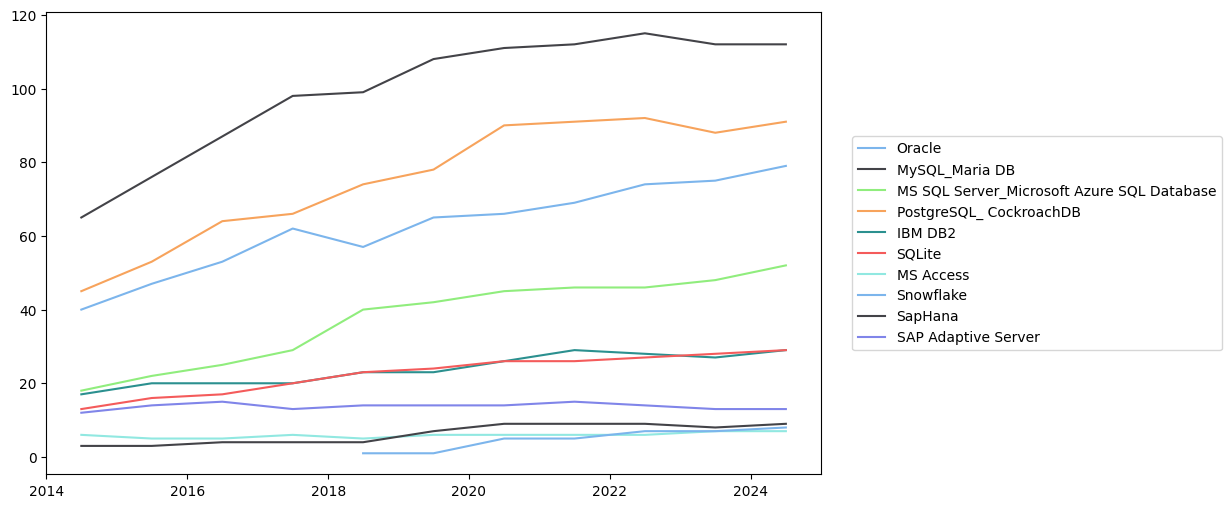

In [17]:
from collections import Counter
from matplotlib import pyplot as plt
fig= plt.figure(figsize=(10,6))
#plt.title("title")
#plt.xlabel("xlabel")
#plt.ylabel("ylabel")

for bd, color in relational_dbs.items():
    counter = Counter()
    for pid, project in projects.items():
        for date, vid in project["dates"].items():
            if bd in version_map.get(vid, []):
                counter[date] += 1
    items = sorted([(d, c) for d,c in counter.items() if d.year >= 2014])
    x = [v[0] for v in items]
    y = [v[1] for v in items]
    #if any(v > 20 for v in y):
    plt.plot(x,y, label=bd, color=color)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0) 
plt.show()

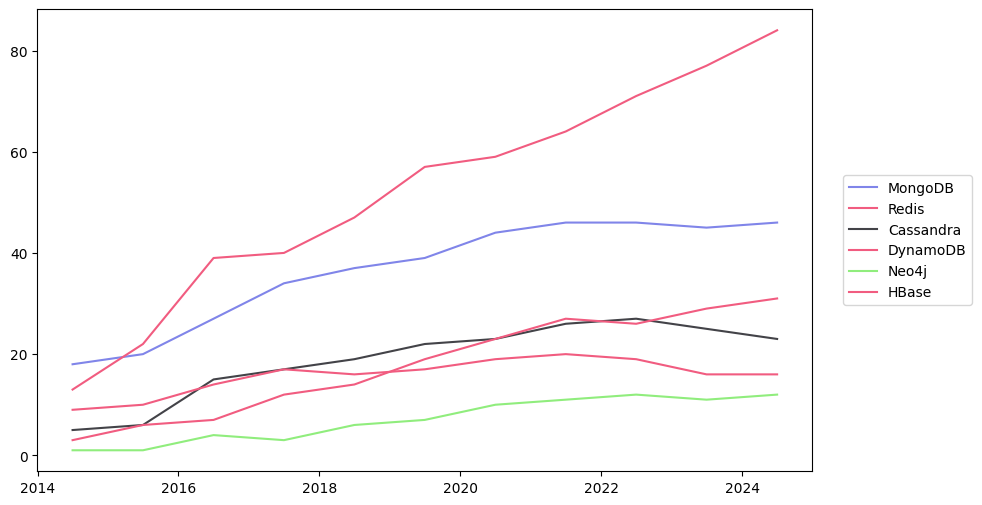

In [19]:
from collections import Counter
from matplotlib import pyplot as plt
fig= plt.figure(figsize=(10,6))
#plt.title("title")
#plt.xlabel("xlabel")
#plt.ylabel("ylabel")

for bd, color in non_relational_dbs.items():
    counter = Counter()
    for pid, project in projects.items():
        for date, vid in project["dates"].items():
            if bd in version_map.get(vid, []):
                counter[date] += 1
    items = sorted([(d, c) for d,c in counter.items() if d.year >= 2014])
    x = [v[0] for v in items]
    y = [v[1] for v in items]
    #if any(v > 20 for v in y):
    plt.plot(x,y, label=bd, color=color)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0) 
plt.show()